In the first half of this notebook, the raw dataset is analyzed and some key metrics like the number of unique F-Terms in the dataset is computed. 

In the second half of this notebook, the scraped definitions of the F-terms are analyzed and the F-Term definitions are embeddet to multiple dictionaries.

# Imports

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from dask import dataframe as dd
import dask
import time
import re
import pickle as pk

# Loading the Dataset to a Dask DataFrame

In [2]:
file = 'data/JPO_patents_abstracts_fterms'
f_term_def_file = r'data/f-terms.csv'

# Using dask because the file is way to big for memory.

data = dask.dataframe.read_parquet(file, delimiter= '\t')


pk_dump_dir = r'PK_DUMP'


#print(f'There are {l_data} patents listed in the dataset')
data.head()
for i, row in data.iterrows():
    print(row['appln_abstract'])
    print(row['jp_class_symbol'])
    break

PURPOSE:A process for producing moisture absorbing filament yarns of wellbalanced yarn properties by spinning composite filament yarns consisting of a polyester as a core and a specific cellulose ester as a sheath, and by hydrolyzing the cellulose ester.
4L031/AA02,4L031/AA18,4L031/AB10,4L031/BA11,4L031/CA01,4L031/DA08,4L041/AA07,4L041/AA20,4L041/AA25,4L041/BA02,4L041/BA05,4L041/BA21,4L041/BC02,4L041/BC20,4L041/CA06,4L041/CA12,4L041/CA57,4L041/DD18,4L041/EE14,4L041/EE15


### len(data)

# Deleting Previous Pickle Files

In [3]:
# Only run this cell when you want to recalculate the number of labels, the text_lengths and the label_embedding

i = input('''Warning! You are about to delete all previously computed files. If you want to continue write "y": ''')

if i == "y":
    with open(pk_dump_dir + r'/n_labels', 'wb') as f:
        pass
    with open(pk_dump_dir + r'/text_lengths', 'wb') as f:
        pass
    with open(pk_dump_dir + r'/label_embedding', 'wb') as f:
        pass

Warning! You are about to delete all previously computed files. If you want to continue write "y":  q


# Extracting the abstract text-lengths and the labels

In [4]:
class LabelEmbedding():
    """
    A class to count the occurrence of each individual label.
    It also creates a dict, which contains each label and matches it to a number
    """
    def __init__(self):
        self.dict = {}
        self.r_dict = {}
        self.occurrence = []
        
        
    def __call__(self, label):
        try: 
            emb = self.dict[label]
            self.occurrence[emb] += 1
        except KeyError:
            emb = len(self.dict)
            self.dict[label] = emb
            self.r_dict[emb] = label
            self.occurrence.append(1)
        
        return emb
    
    def __len__(self):
        return len(self.dict)
    
    def reverse(self, emb):
        return self.r_dict[emb]

In [5]:
# Run this cell only on your first run of this notebook, it takes really long.
# All outputs will be saved and can be loaded from disk in 
# all following runs of this notebook.


i = input('''Warning! You are about to recalculate all metric files. This will take a wile!
If you want to continue write "y": ''')


n_labels = []
text_lengths = []
    
def get_text_lengths(line):
    """
    Returns the length of the patent abstract.
    """
    text = line['appln_abstract']
    text = text.split()
    return len(text)
    
    
def get_labels(line):
    """
    Returns the f_term labels of a patent as a list of strings.
    """
    f_terms = line['jp_class_symbol']
    f_terms = f_terms.split(',')
    return f_terms
    
    
class LabelEmbedding():
    def __init__(self):
        self.dict = {}
        self.r_dict = {}
        self.occurrence = []
            
            
    def __call__(self, label):
        try: 
            emb = self.dict[label]
            self.occurrence[emb] += 1
        except KeyError:
            emb = len(self.dict)
            self.dict[label] = emb
            self.r_dict[emb] = label
            self.occurrence.append(1)
            
        return emb
        
    def __len__(self):
        return len(self.dict)
        
    def reverse(self, emb):
        return self.r_dict[emb]
    
if i == "y":
    # Iterating over the whole dataset and extracting the text_lengths and the labels
    label_embedding = LabelEmbedding()
    for i, line in enumerate(data.iterrows()):
        
        # Processing the data
        line = line[1]
        labels_split = get_labels(line)
        labels_split = [label_embedding(label) for label in labels_split]
        
        # storing in lists
        n_labels.append(len(labels_split))
        text_lengths.append(get_text_lengths(line))
        
        if i%1000 == 0:
            print(f'Processed {i} samples', end='\r')
            
        if i == n_load:
            # Stopping when finnished
            with open(pk_dump_dir + r'/n_labels', 'ab') as f:
                pk.dump(n_labels, f)
                n_labels = []
            with open(pk_dump_dir + r'/text_lengths', 'ab') as f:
                pk.dump(text_lengths, f)
                text_lengths = []
            break
            
        if i%100000 == 0 and i != 0:
            # Saving chunks of processed data to not overflow the memory
            with open(pk_dump_dir + r'/n_labels', 'ab') as f:
                pk.dump(n_labels, f)
                n_labels = []
            with open(pk_dump_dir + r'/text_lengths', 'ab') as f:
                pk.dump(text_lengths, f)
                text_lengths = []
    
    # Saving the label_embedding to access them faster in the next runs of this notebook
    with open(pk_dump_dir + r'/label_embedding', 'ab') as f:
                pk.dump(label_embedding, f)

Warning! You are about to recalculate all metric files. This will take a wile!
If you want to continue write "y":  x


# Number of Labels in Dataset

In [6]:
with open(pk_dump_dir + r'/label_embedding', 'rb') as f: 
    label_embedding = pk.load(f)

print(f'Number of F-Term Labels in Dataset = {len(label_embedding)}')

Number of F-Term Labels in Dataset = 519042


# Plotting the Word Counts


NameError: name 'n_load' is not defined

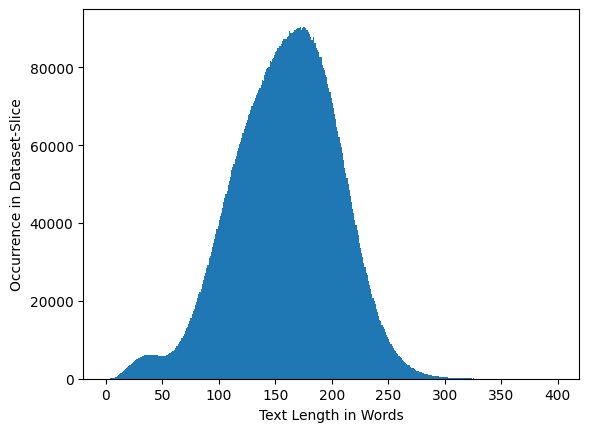

In [7]:
# Loading the list from Memory

with open(pk_dump_dir + r'/text_lengths', 'rb') as f:
    text_lengths = []
    while True:
        try: 
            text_lengths.extend(pk.load(f))
        except EOFError:
            break
       
hist_wc = plt.hist(text_lengths, bins=[i for i in range(400)])
plt.xlabel('Text Length in Words')
plt.ylabel('Occurrence in Dataset-Slice')
plt.title(f'Patent Abstract Word Counts in {n_load} Samples')
plt.show()

# Plotting the Labels per Patent

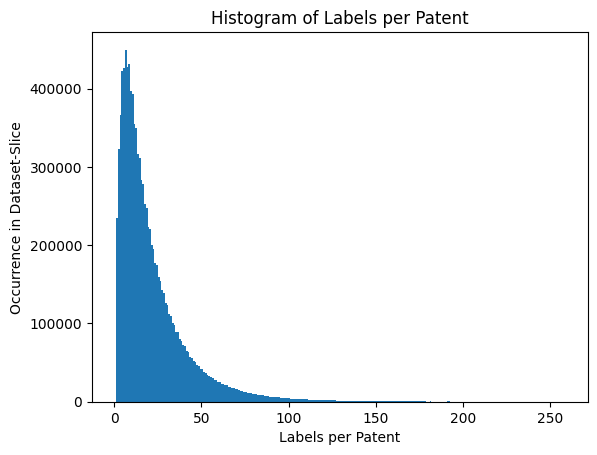

In [9]:
with open(pk_dump_dir + r'/n_labels', 'rb') as f:
    n_labels = []
    while True:
        try: 
            n_labels.extend(pk.load(f))
        except EOFError:
            break

hist_lpp = plt.hist(n_labels, bins=[i for i in range(260)])
plt.xlabel(f'Labels per Patent')
plt.ylabel('Occurrence in Dataset-Slice')
plt.title('Histogram of Labels per Patent')
plt.show()

In [10]:
print(f'On average each patent has {np.mean(n_labels)}')

On average each patent has 21.253875353407985


In [12]:
np.sum(n_labels)/378165

595.748152261579

In [ ]:
# Getting the number of patents with just one label
l_single = hist_lpp[0][1]

print(f'''
There are {l_single} patents that only have one label! ''')

# Counting the Occurrence of Each Label


In [ ]:
occurrences = label_embedding.occurrence


print(f'The maximum occurrence of a label is {max(occurrences)} times in the {n_load} samples dataset-slice.')

# Plotting the Label Occurrences


In [ ]:
hist = plt.hist(occurrences, bins=np.arange(500))
plt.title(f'Occurrences of Labels in {n_load} Samples')
plt.xlabel(f'Occurrence of Label in Dataset')
plt.ylabel(f'Labels With this Occurrence')
plt.show()

In [ ]:
ind = np.argwhere(np.array(occurrences) == 1)
l_one_time = len(np.array(occurrences)[ind])
print(f'There are {l_one_time} labels that only occur once in the dataset-slice.')

# All F-Terms in the Dataset

In [ ]:
f_terms = [k for k, v in label_embedding.dict.items()]

# Splitting the F-Terms 

In [ ]:
def split_f_term(f_term):
    """
    This function splits an f_term into a hirachical order of classes.
    
    :f_term:   string: f_term as a string
    
    :return:   list of strings: f_term classes as a list of strings.
    """
    try:
        theme_code, term_code = f_term.split('/')
    except Exception:
        return f_term, '', '', ''
    view_point = term_code[:2]
    digit = term_code[2:4]
    additional_code = term_code[4:]
    #print(f'theme-code: {theme_code}, term-code: {term_code}, view_point: {view_point}, digit: {digit}, additional-code: {additional_code}')
    return theme_code, view_point, digit, additional_code
    

classes_list = [split_f_term(f_term) for f_term in f_terms]
classes = pd.DataFrame(classes_list, columns=["theme", "viewpoint", "number", "additional code"])
classes.head()

# Loading the F-Term Definitions File

In [ ]:
# Loading the defenitions of the F-Terms
f_term_def = pd.read_csv(f_term_def_file)
print(f'There are {len(f_term_def)} entrys in the F-Terms CSV file')
f_term_def.head()

In [ ]:
# Counting the number of themes.
themes = f_term_def['theme']
n_themes = len(set(themes))
theme_labels = f_term_def['theme_label']
n_theme_labels = len(set(theme_labels))
print(f'There are {n_themes} unique themes and number {n_theme_labels} theme-labels in the f-terms CSV-file!')

In [ ]:
# Checking for contradicting theme - theme_label definitions
current_theme = ''
current_label = ''
n_missmatches = 0
for i, row in f_term_def[['theme', 'theme_label']].iterrows():
    theme, theme_label = row
    if theme != current_theme and theme_label != current_label:
        current_theme = theme
        current_label = theme_label
    elif theme != current_theme or theme_label != current_label:
        if theme == current_theme and theme_label!=theme_label:
            continue
        n_missmatches += 1
        print(f'''Double Match Found:
        
Theme= {theme}, expected theme= {current_theme}
Label= {theme_label}, expected label = {current_label}
''')
        current_theme = theme
        current_label = theme_label

### There are several theme_labels attributed to more than one theme. 
### There are also theme_labels which are nan

In [ ]:
# Dropping all duplicate theme rows, but keeping duplicate theme_labels
themes_and_labels = f_term_def[['theme', 'theme_label']]
themes_and_labels = themes_and_labels.drop_duplicates(subset=['theme'])
l_d = len(themes_and_labels)

print(f'''Number of themes after dropping duplicates: {l_d}''')

# Theme-Label Issues


In [ ]:
# There are several small issues concerning the theme-labels

# Inconsistent usage of large and lower case
themes_and_labels.iloc[44:46]

In [ ]:
# Untranslated words:

themes_and_labels.iloc[1874:1877]

In [ ]:
# Bad theme descriptions with little differentiation

pd.options.display.max_colwidth = 100
themes_and_labels.iloc[1952: 1956]

In [ ]:
t_df = classes['theme']

print(f'Problem: There are {len(set(t_df))} unique themes in the dataset-slice, but only {len(themes_and_labels)} themes in the dataset_dict')

# Create (incomplete) F-Terms Dictionaries

In [ ]:
def extract_number(raw_number):
    if raw_number != raw_number:
        return ''
    return re.findall(r'\d+', raw_number)[0]

def extract_information_from_line(line):
    theme = line["theme"]
    viewpoint = line["viewpoint"]
    number = line["number"]
        
    # some numbers are nan, droppin these, removing viewpoint from number
    exact_number = extract_number(number)
        
    # checking for nan in viewpoint
    if viewpoint != viewpoint:
        # number also contains view-point
        if number != number:
            number = ''
        viewpoint = number
        exact_number = ''
            
    theme_txt = str(line['theme_label']).lower()
    viewpoint_txt = str(line['viewpoint_label']).lower()
    number_txt = str(line['label']).lower()
    
    return [theme, theme_txt, viewpoint, viewpoint_txt, exact_number, number_txt]


def clean_data(f_term_definitions):
    """
    :f_term_definitions: pd.DataFrame: Loaded CSV file
    
    :return: Dataframe with cleand data
    """
    
    extracted_data = [extract_information_from_line(line) for i, line in f_term_definitions.iterrows()]
    extracted_data = pd.DataFrame(extracted_data, columns=['theme', 'theme_label', 'viewpoint', 'viewpoint_label', 'number', 'label'])
    return extracted_data
    
    
clean_data = clean_data(f_term_def)
clean_data.head()

In [ ]:
def create_dicts(clean_f_terms):
    """
    Creates dictionarys to look up the description of themes, viewpoints and numbers for all f-terms in the f-term-definitions
    file.
    """
    theme_df = clean_f_terms[['theme', 'theme_label']]
    theme_df = theme_df.drop_duplicates(subset=['theme'])
    theme_dict = {line[0]: line[1] for i, line in theme_df.iterrows()}
    
    viewpoint_df = clean_f_terms[['theme', 'viewpoint', 'viewpoint_label' ]]
    viewpoint_df['theme_viewpoint'] = viewpoint_df['theme'] + '/' + viewpoint_df['viewpoint']
    viewpoint_df = viewpoint_df[['theme_viewpoint', 'viewpoint_label']]
    viewpoint_dict = {line[0]: line[1] for i, line in viewpoint_df.iterrows()}
       
    number_df = clean_f_terms[['theme', 'viewpoint', 'number', 'label']]
    number_df['key'] = number_df['theme'] + '/' + number_df['viewpoint'] + number_df['number']
    number_df = number_df[['key', 'label']]
    number_dict = {line[0]: line[1] for i, line in number_df.iterrows()}

    
    full_definitions_df = clean_f_terms[['theme', 'viewpoint', 'number', 'theme_label', 'viewpoint_label', 'label']]
    full_definitions_df['key'] = full_definitions_df['theme'] + '/' + full_definitions_df['viewpoint'] + full_definitions_df['number']
    full_definitions_df['description'] = full_definitions_df['theme_label'] + full_definitions_df['viewpoint_label'] + full_definitions_df['label']
    full_definitions_df = full_definitions_df[['key', 'description']]
    full_definitions_dict = {line[0]: line[1] for i, line in full_definitions_df.iterrows()}
    
    return {'theme_dict': theme_dict, 
            'viewpoint_dict': viewpoint_dict, 
            'number_dict': number_dict,
            'full_definitions_dict': full_definitions_dict}
    
f_term_dicts = create_dicts(clean_data)

theme_dict = f_term_dicts['theme_dict']
viewpoint_dict = f_term_dicts['viewpoint_dict']
number_dict = f_term_dicts['number_dict']
full_description_dict = f_term_dicts['full_definitions_dict']


with open(f'{pk_dump_dir}/themes_descriptions.pk', 'wb') as f:
    pk.dump(theme_dict, f)
with open(f'{pk_dump_dir}/viewpoints_descriptions.pk', 'wb') as f:
    pk.dump(viewpoint_dict, f)
with open(f'{pk_dump_dir}/numbers_descriptions.pk', 'wb') as f:
    pk.dump(number_dict, f)


In [ ]:
with open(f'{pk_dump_dir}/full_descriptions.pk', 'wb') as f:
    pk.dump(full_description_dict, f)

In [ ]:
for key, value in full_description_dict.items():
    print(key, value)
    for i in range(10000):
        x = 1*1

In [ ]:
with open(f'{pk_dump_dir}/f_term_dict.pk', 'wb') as f:
    pk.dump(number_dict, f)

In [ ]:
def convert_to_numpy(list_of_classes):
    """
    This function converts a list of string-classes created by calling the split_f_term-function on all samples in the 
    dataset-splice to a numpyarray and also returns a dict of usefull dicts for recreating the original labels.
    
    :list_of_classes:  list of strings: List of classes produced by the split_f_term-function.
    
    :returns:          Numpy array: List of classes imbedded in an numpy array.
    :returns:          dict of dicts: Dict with all dicts needed to recreate the orignial classes.
    """
    theme_codes = set([c[0] for c in list_of_classes])
    viewpoints = set([c[1] for c in list_of_classes])
    digits = set([c[2] for c in list_of_classes])
    additional_code = set([c[3] for c in list_of_classes])

    theme_codes_dict = {x: i for i, x in enumerate(theme_codes)}
    viewpoints_dict = {x: i for i, x in enumerate(viewpoints)}
    digits_dict = {x: i for i, x in enumerate(digits)}
    additional_code_dict = {x: i for i, x in enumerate(additional_code)}
    
    list_of_classes = [[theme_codes_dict[t], viewpoints_dict[v], digits_dict[d], additional_code_dict[a]] 
                       for t, v, d, a in list_of_classes]
    
    list_of_classes = np.array(list_of_classes)
    
    reversed_theme_codes_dict = {v: k for k, v in theme_codes_dict.items()}
    reversed_viewpoints_dict = {v: k for k, v in viewpoints_dict.items()}
    reversed_digits_dict = {v: k for k, v in digits_dict.items()}
    reversed_additional_code_dict = {v: k for k, v in additional_code_dict.items()}
    
    dicts_dict = {'reversed_theme_codes_dict': reversed_theme_codes_dict,
                  'reversed_viewpoints_dict': reversed_viewpoints_dict,
                  'reversed_digits_dict': reversed_digits_dict,
                  'reversed_additional_code_dict': reversed_additional_code_dict, 
                  
                  'theme_codes_dict': theme_codes_dict,
                  'viewpoints_dict': viewpoints_dict,
                  'digits_dict': digits_dict,
                  'additional_code_dict': additional_code_dict}
    return list_of_classes, dicts_dict

In [ ]:
np_classes, dictofdicts = convert_to_numpy(classes_list)

# Counting the Occurrence of Each Class

In [ ]:
# Theme classes
theme_keys, theme_occ = np.unique(np_classes[:,0], return_counts=True)
ind = np.argsort(theme_occ)
theme_keys, theme_occ = theme_keys[ind], theme_occ[ind]

# Viewpoints classes
view_keys, view_occ = np.unique(np_classes[:,1], return_counts=True)
ind = np.argsort(view_occ)
view_keys, view_occ = view_keys[ind], view_occ[ind]

# Digits classes
digits_keys, digits_occ = np.unique(np_classes[:, 2], return_counts=True)
ind = np.argsort(digits_occ)
digits_keys, digits_occ = digits_keys[ind], digits_occ[ind]

# Additional Code classes
code_keys, code_occ = np.unique(np_classes[:, 3], return_counts=True)
ind = np.argsort(code_occ)
code_keys, code_occ = code_keys[ind], code_occ[ind]
